<a href="https://colab.research.google.com/github/aniketmaurya/GANs-PyTorch/blob/main/DCGAN/dc_gan_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DC-GAN

**Paper: Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks**

**Link: https://arxiv.org/abs/1511.06434**

**Authors: Alec Radford, Luke Metz, Soumith Chintala**

## Abstract
In recent years, supervised learning with convolutional networks (CNNs) has seen huge adoption in computer vision applications. Comparatively, unsupervised learning with CNNs has received less attention. In this work we hope to help bridge the gap between the success of CNNs for supervised learning and unsupervised learning. We introduce a class of CNNs called deep convolutional generative adversarial networks (DCGANs), that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning. Training on various image datasets, we show convincing evidence that our deep convolutional adversarial pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator. Additionally, we use the learned features for novel tasks - demonstrating their applicability as general image representations.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!pip install pytorch-lightning -q
!pip install pytorch-lightning-bolts -q

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from tqdm.notebook import tqdm

from glob import glob
import matplotlib.pyplot as plt

import pytorch_lightning as pl

torch.manual_seed(0)

In [14]:
# # run this if want to train on kaggle dataset
# # copy kaggle key to /root/.kaggle/kaggle.json
# import os
# os.makedirs('/root/.kaggle')
# !cp ./kaggle.json /root/.kaggle/kaggle.json
# !kaggle datasets download -d jessicali9530/celeba-dataset
# !unzip -qq ./celeba-dataset.zip
path = './img_align_celeba/img_align_celeba'

In [26]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), ret=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
# Configurations are from DCGAN paper
z_dim = 100
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

display_step = 500

## Create dataloader

In [4]:
from PIL import Image

In [5]:
# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [15]:
# Run this if want to load kaggle dataset

class ImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = glob(f'{path}/*')

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        label = file.split('/')[-1]
        image = Image.open(file)
        if self.transform:
            image = self.transform(image)
        return image, label


ds = ImageDataset(path, transform=transform)
dataloader = dl = DataLoader(ds,
                             batch_size=batch_size,
                             shuffle=True)

In [ ]:
# # uncomment if using Pytorch datasets
# ds = datasets.CelebA('.',
#                     download=True,
#                     transform=transform)
# dataloader = dl = DataLoader(ds,
#                              batch_size=batch_size,
#                              shuffle=True)

# Network

GANs are made up of two entities - Generator and Discriminator.

## Generator
Generator learns the data distribution and creates fake images.

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, z_dim=100):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.create_upblock(z_dim,
                                1024,
                                kernel_size=4,
                                stride=1,
                                padding=0),
            self.create_upblock(1024, 512, kernel_size=4, stride=2, padding=1),
            self.create_upblock(512, 256, kernel_size=4, stride=2, padding=1),
            self.create_upblock(256, 128, kernel_size=4, stride=2, padding=1),
            self.create_upblock(128,
                                3,
                                kernel_size=4,
                                stride=2,
                                padding=1,
                                final_layer=True),
        )

    def create_upblock(self,
                       in_channels,
                       out_channels,
                       kernel_size=5,
                       stride=2,
                       padding=1,
                       final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels,
                                   out_channels,
                                   kernel_size,
                                   stride,
                                   padding,
                                   bias=False), nn.BatchNorm2d(out_channels),
                nn.Tanh())
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size,
                               stride,
                               padding,
                               bias=False), nn.BatchNorm2d(out_channels),
            nn.ReLU(True))

    def forward(self, noise):
        """
        noise: random vector of shape=(N, 100, 1, 1)
        """
        assert len(noise.shape) == 4, 'random vector of shape=(N, 100, 1, 1)'

        return self.gen(noise)


def get_noise(bs, z_dim):
    noise = torch.randn(bs, z_dim, 1, 1, device=device)
    return noise

# Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=32):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4, stride=1),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 4, stride=2),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self,
                        input_channels,
                        output_channels,
                        kernel_size=4,
                        stride=2,
                        final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size,
                          stride), nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2))
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size,
                          stride))

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [9]:
criterion = nn.BCEWithLogitsLoss()

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [48]:
class GAN(pl.LightningModule):
    def __init__(self,
                 learning_rate,
                 in_channels=3,
                 hidden_dim=32,
                 z_dim=100,
                 **kwargs):
        super().__init__()

        self.z_dim = z_dim
        self.learning_rate = learning_rate

        self.gen = Generator(in_channels, z_dim=z_dim).to(device)
        self.disc = Discriminator(im_chan=in_channels,
                                  hidden_dim=hidden_dim).to(device)

        self.gen.apply(weights_init)
        self.disc.apply(weights_init)

        self.save_hyperparameters()

    def forward(self, noise):
        # in lightning, forward defines the prediction/inference actions
        return self.gen(noise)

    def disc_step(self, x, noise):
        """
        x: real image
        """
        # generate fake images
        # noise = get_noise(x.shape[0], self.z_dim)
        fake_images = self.gen(noise)

        # get discriminator outputs
        real_logits = self.disc(x)
        fake_logits = self.disc(fake_images.detach())

        assert real_logits.shape == fake_logits.shape, f"Real and fake logit shape are different: {real_logits.shape} and {fake_logits.shape}"

        # real loss
        real_loss = criterion(real_logits, torch.ones_like(real_logits))

        # fake loss
        fake_loss = criterion(fake_logits, torch.zeros_like(fake_logits))

        disc_loss = (fake_loss + real_loss) / 2

        assert disc_loss is not None
        self.log('disc_loss', disc_loss, on_epoch=True, prog_bar=True)
        return disc_loss

    def gen_step(self, x, noise):
        # generate fake images
        # noise = get_noise(x.shape[0], self.z_dim)
        fake_images = self.gen(noise)

        fake_logits = self.disc(fake_images)
        fake_loss = criterion(fake_logits, torch.ones_like(fake_logits))

        gen_loss = fake_loss

        assert gen_loss is not None
        self.log('gen_loss', gen_loss, on_epoch=True, prog_bar=True)
        return gen_loss

    def training_step(self, batch, batch_idx, optimizer_idx):
        x, _ = batch
        x = real = x.to(device)
        noise = get_noise(real.shape[0], self.z_dim)
        assert real.shape[1:] == (3, 64, 64), f"batch image data shape is incorrect: {real.shape}"

        if batch_idx % display_step==0 and optimizer_idx == 0:
            fake_images = self.forward(noise)

            show_tensor_images(fake_images)
            show_tensor_images(real)
            

        loss = None
        # first get gen loss [opt_g, opt_d]
        if optimizer_idx == 0:
            loss = self.gen_step(real, noise)

        if optimizer_idx == 1:
            loss = self.disc_step(real, noise)
        return loss

    def configure_optimizers(self):
        lr = self.hparams.learning_rate

        opt_g = torch.optim.Adam(self.gen.parameters(),
                                 lr=lr,
                                 betas=(beta_1, beta_2))
        opt_d = torch.optim.Adam(self.disc.parameters(),
                                 lr=lr,
                                 betas=(beta_1, beta_2))
        return [opt_g, opt_d]

In [49]:
model = GAN(learning_rate=lr, z_dim=z_dim)
trainer = pl.Trainer(max_epochs=20, gpus=1)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 12.7 M
1 | disc | Discriminator | 430 K 
---------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params


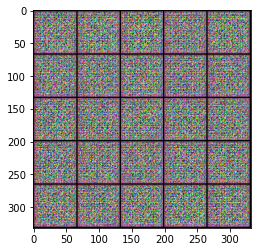

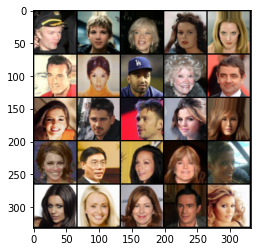

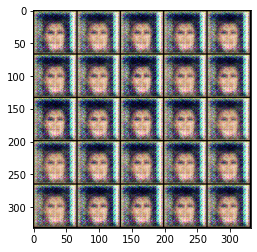

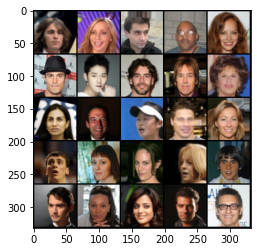

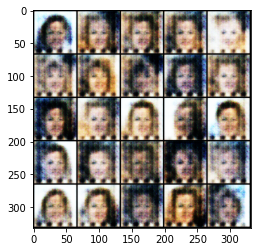

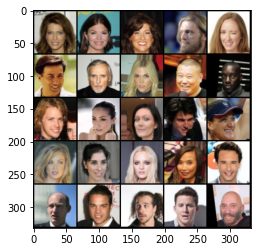

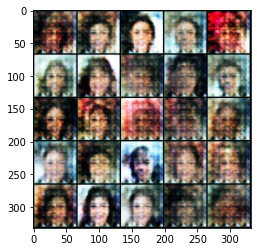

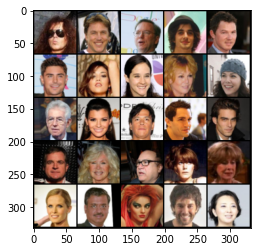

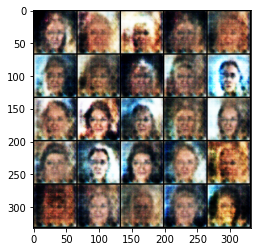

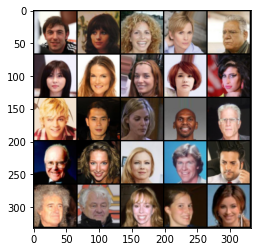

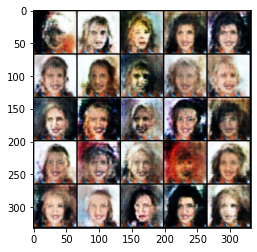

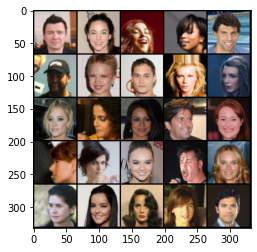

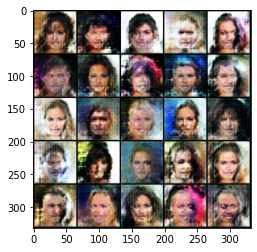

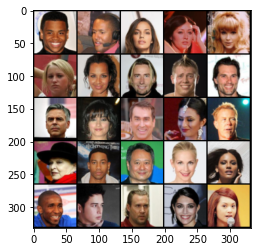

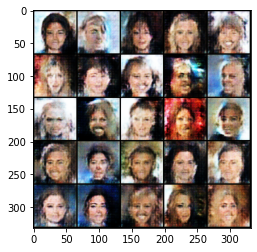

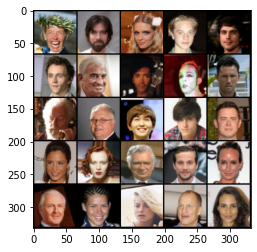

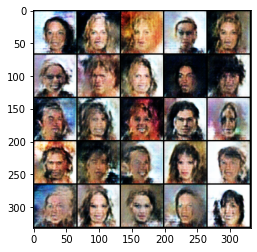

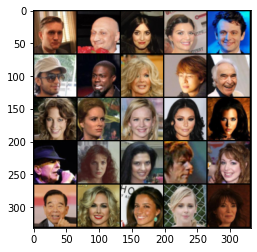

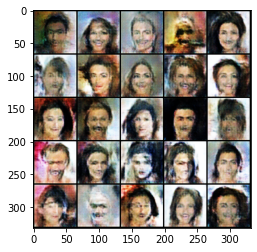

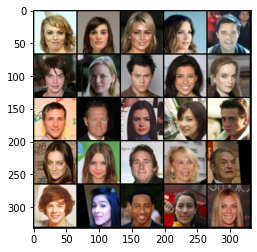

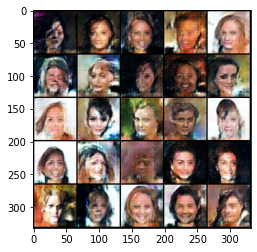

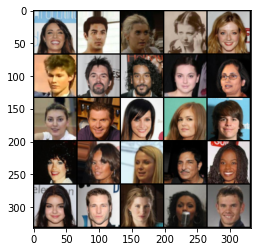

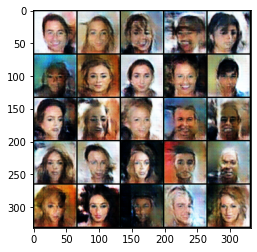

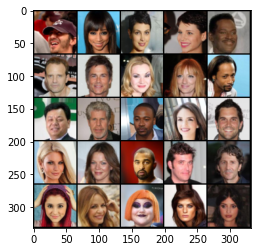

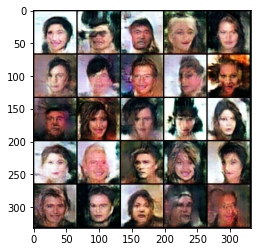

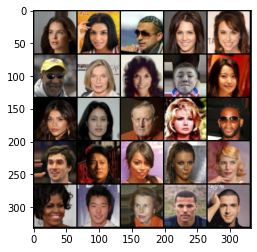

In [ ]:
trainer.fit(model, dl)